### Effective degrees of freedom of the Pearson's correlation coefficient under autocorrelation

Functional connectivity refers to the temporal dependence between pairs of brain regions measured with fMRI. This can be quantified using Pearson's correlation, but this measure is biased if the timeseries themselves are autocorrelated. This is often the case with fMRI data because of low frequency oscillatory patterns in the BOLD timecourse. The severity of autocorrelation can vary depending on the parcellation atlas used to divide the brain into regions of interest (ROIs), and the size and location of these ROIs within the brain.  

The "xDF" method proposed by [Afyouni, Smith, and Nichols (2019)](https://www.sciencedirect.com/science/article/pii/S1053811919303945) addresses autocorrelation within each distinct ROI as well as instantaneous and lagged cross-correlation between ROI pairs. Simulations under the null setting (no cross-correlation between ROIs) show that xDF correction has better control of false positives when compared to no correction or methods based on more simplistic autocorrelation assumptions. Further, simulations with realistic autocorrelation and non-null cross-correlation show that xDF has negligible bias across increasing degrees of autocorrelation.

In summary, the xDF method has better control of false positives and unbiased standard errors over a range of settings. The authors recommend the use of xDF when computing functional connectivity statistics that depend on the standard errors of correlation coefficients - such as standardized Z-scores, graph theoretical measures, or mixed-effects models. 

**Retrieve the data and atlases (Yeo 2011, Power 2011)**

In [ ]:
import ac_utils
import numpy as np
import xdf
from matplotlib import pyplot as plt
from nilearn import (connectome, datasets, glm, image, maskers, plotting,
                     regions)
from scipy.spatial.distance import euclidean

# fetch fMRIPrep functional data and confounds (from 33 subjects)
data = datasets.fetch_development_fmri(age_group="adult")
mni = datasets.fetch_icbm152_2009()
mask = image.resample_to_img(mni.mask, data.func[0], interpolation="nearest")

# fetch atlases
yeo = datasets.fetch_atlas_yeo_2011().thick_17

# assign each region of yeo atlas to a unique label
yeo = regions.connected_label_regions(yeo, min_size=100)

power = (
    datasets.fetch_coords_power_2011(legacy_format=False)
    .rois[["x", "y", "z"]]
    .to_numpy()
)


# initialze maskers
kwargs = dict(standardize=True, memory="nilearn_cache")
masker_voxels = maskers.NiftiMasker(mask_img=mask, reports=False, **kwargs)
masker_yeo = maskers.NiftiLabelsMasker(labels_img=yeo, reports=False, **kwargs)
masker_power = maskers.NiftiSpheresMasker(seeds=power, radius=5, **kwargs)

**Show the difference in autocorrelation structure between two regions**

Text(25, 0.1712140870390309, '95% CI')

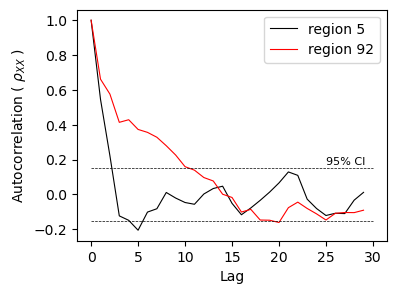

In [2]:
# extract mean timeseries for each region of the yeo atlas
X_ex = masker_yeo.fit_transform(data.func[-1], confounds=data.confounds[-1])
n_timepoints = X_ex.shape[0]

# calculate the full-lag autocorrelation function using FFT
X_ac, ci = ac_utils.ac_fft(X_ex.T, X_ex.shape[0])

# plot two example regions (first 30 lags)
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(X_ac[5, :30], lw=0.8, c="k", label="region 5")
ax.plot(X_ac[92, :30], lw=0.8, c="r", label="region 92")
ax.legend()
ax.set_xlabel("Lag")
ax.set_ylabel(r"Autocorrelation ( $\rho_{XX}$ )")

# plot confidence intervals
ax.hlines(ci, 0, 30, lw=0.5, color="k", linestyle="dashed")
ax.text(25, ci[1] + 0.02, "95% CI", fontsize=8)


**Extract the timeseries data from voxels and regions defined by the atlases**

For each voxel/region in $X$, calculate the autocorrelation index (ACI) to summarize the strength of autocorrelation.

\begin{equation}
\tau_X = \sum_{i=0}^{N-1} \rho^2_{XX, i}
\end{equation}

In [3]:
# !!! 3 min runtime !!!


def calc_aci(X, n_timepoints):
    """return the autcorrelation index for each voxel/region"""
    X_ac, _ = ac_utils.ac_fft(X, n_timepoints)
    return np.sum(X_ac**2, axis=1)


aci = {"voxels": [], "yeo": [], "power": []}

# loop over subjects
for func, confounds in zip(data.func, data.confounds):

    # voxelwise autocorrelation index
    X_voxels = masker_voxels.fit_transform(func, confounds=confounds)
    aci["voxels"].append(calc_aci(X_voxels.T, n_timepoints=n_timepoints))

    # yeo atlas autocorrelation index
    X_yeo = masker_yeo.fit_transform(func, confounds=confounds)
    aci["yeo"].append(calc_aci(X_yeo.T, n_timepoints=n_timepoints))

    # power atlas autocorrelation index
    X_power = masker_power.fit_transform(func, confounds=confounds)
    aci["power"].append(calc_aci(X_power.T, n_timepoints=n_timepoints))

# average across subjects
aci = {key: np.array(val).mean(axis=0) for key, val in aci.items()}


**Map the variation in strength of autocorrelation over the brain, averaged across subjects**

The degree of autocorrelation in fMRI data is heterogeneous over the brain. Using a parcellation scheme magnifies this effect because of averaging voxels within regions - larger regions have a higher ACI. This demonstrates the importance of node-specific autocorrelation adjustment.

/usr/local/Caskroom/miniconda/base/envs/xdf/lib/python3.10/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


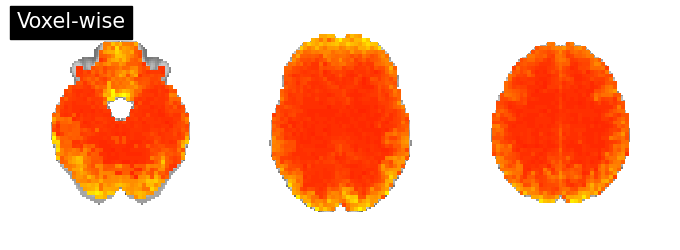

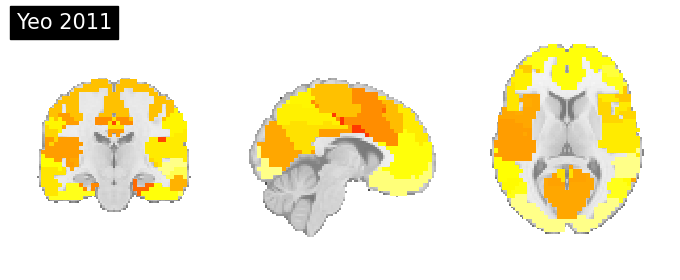

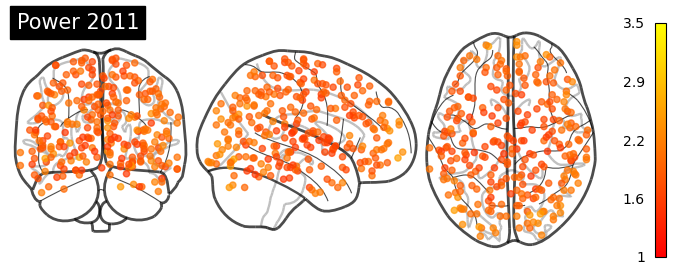

In [4]:
plot_kwargs = dict(
    threshold=1, vmax=3.5, annotate=False, draw_cross=False, colorbar=False
)

# voxelwise autocorrelation index
plotting.plot_stat_map(
    masker_voxels.inverse_transform(aci["voxels"]),
    title="Voxel-wise",
    display_mode="z",
    cut_coords=(-20, 0, 30),
    **plot_kwargs,
)

# yeo atlas autocorrelation index
plotting.plot_stat_map(
    masker_yeo.inverse_transform(aci["yeo"]),
    title="Yeo 2011",
    **plot_kwargs,
)

# power atlas autocorrelation index
plotting.plot_markers(
    aci["power"],
    power,
    title="Power 2011",
    node_cmap="autumn",
    node_vmin=1,
    node_vmax=3.5,
    node_size=20,
    annotate=False,
)


**Cortical nodes have systematically higher autocorrelation than subcortical nodes**

Plot ACI versus distance to the center of the brain (thalamus) using the Power atlas which has identically-sized spherical nodes.

Text(0, 0.5, 'Autocorrelation Index ($\\tau$)')

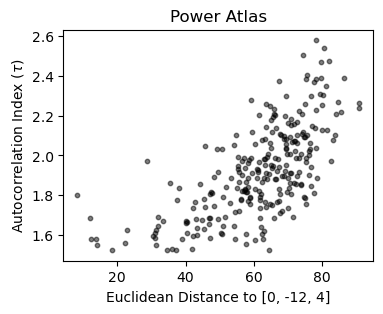

In [5]:
center = [0, -12, 4]  # fig2-D, thalamus coordinates

# calculate euclidean distance to thalamus for each region
distances = [euclidean(center, coords) for coords in power]

# plot results
fig, ax = plt.subplots(figsize=(4, 3))

ax.scatter(distances, aci["power"], alpha=0.5, s=10, c="k")
ax.set_title("Power Atlas")
ax.set_xlabel(f"Euclidean Distance to {center}")
ax.set_ylabel(r"Autocorrelation Index ($\tau$)")


**Larger nodes have systematically higher autocorrelation than smaller nodes**  

Plot ACI versus region size using the Yeo atlas defining 95 different sized regions.

Text(0, 0.5, 'Autocorrelation Index ($\\tau$)')

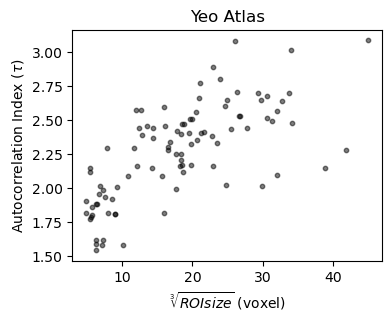

In [6]:
yeo_data = image.get_data(yeo)

# loop through yeo regions
sizes = [
    len(yeo_data[yeo_data == region]) ** (1 / 3) for region in np.unique(yeo_data)[1:]
]

# plot results
fig, ax = plt.subplots(figsize=(4, 3))
ax.scatter(sizes, aci["yeo"], alpha=0.5, s=10, c="k")
ax.set_title("Yeo Atlas")
ax.set_xlabel(r"$\sqrt[3]{ROI size}$ (voxel)")
ax.set_ylabel(r"Autocorrelation Index ($\tau$)")


**Variance of sample correlation coefficients**

The xDF formula provides estimates of the standard errors of correlation coefficients accounting for 
1) autocorrelations within each node timeseries ($\rho_{XX}, \rho_{YY}$) and 
2) instantaneous ($\rho_{XY,0}$) and lagged ($\rho_{XY, \pm i}$) cross-correlations between node pairs.

\begin{aligned}
V(\hat{\rho}_{xy, 0}) &= N^{-2} [(N - 2) (1 - \rho^2)] \\
&+ \rho^2 \sum_i^M w_i (\rho^2_{xx, i} + \rho^2_{yy, i} + \rho^2_{xy, +i} + \rho^2_{xy, -i}) \\
&- 2\rho \sum_i^M w_i (\rho_{xx, i} + \rho_{yy, i}) (\rho_{xy, +i} + {\rho_{xy, -i}}) \\
&+ 2 \sum_i^M w_i (\rho_{xx, i} + \rho_{yy, i} + \rho_{xy, +i} * \rho_{xy, -i})
\end{aligned}

**Generate null realizations by randomly exchanging regions between subjects**  

Due to the random nature of the resting-state BOLD timeseries between subjects, we expect 5% of the correlation coefficients between two randomly picked timeseries from subject $u$ and subject $q$, $\hat{\rho}_{u,q}$ to be significant at $\alpha=0.05$ (i.e $\approx$ 5 regions).

In [7]:
# swap `max_aci` between the two subjects
X_u = masker_yeo.fit_transform(data.func[0], confounds=data.confounds[0])
X_p = masker_yeo.fit_transform(data.func[-1], confounds=data.confounds[-1])

X_aci = calc_aci(X_u.T, n_timepoints=n_timepoints)
max_aci = X_aci.argmax()
min_aci = X_aci.argmin()

X_null = np.concatenate((X_u[:, [min_aci, max_aci]], X_p), axis=1)


**Evaluate the false positive rate control for testing $\rho=0$ to illustrate the problem of inflated correlation estimates under autocorrelation**

Ensure independence between timeseries by sampling each region in the analysis from different subjects. This null realization is used to evaluate the distributions of Z-scores and the false positive rate (FPR). 

calc_xdf::: Time series standardised by their standard deviations.
calc_xdf::: AC Regularisation: Adaptive Truncation
calc_xdf::: NO truncation to the theoritical variance.


Text(0, 0.5, 'xDF Adjusted Z-scores')

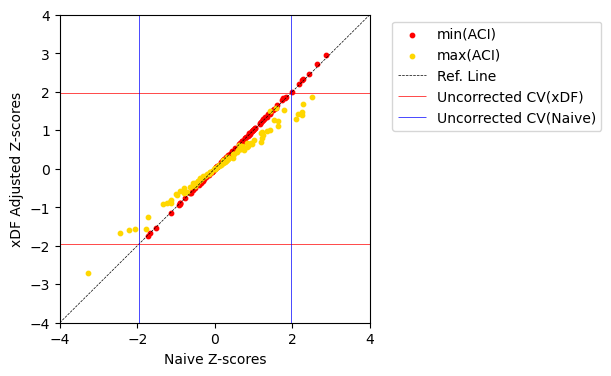

In [8]:
# apply xDF adjustment when the null is true
xdf_null = xdf.calc_xdf(X_null.T, n_timepoints=n_timepoints, truncate_variance=False)
# extract null column vectors
z_naive = xdf_null["znaive"]
z_xdf = xdf_null["z"]

# plot results
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(z_naive[:, 0], z_xdf[:, 0], s=10, c="r", label="min(ACI)")  # min aci
ax.scatter(z_naive[:, 1], z_xdf[:, 1], s=10, c="gold", label="max(ACI)")  # max aci

limits = [-4, 4]
ax.set_xlim(*limits)
ax.set_ylim(*limits)
ax.plot(limits, limits, c="k", lw=0.5, ls="dashed", label="Ref. Line")

ax.hlines([-1.96, 1.96], *limits, lw=0.5, color="r", label="Uncorrected CV(xDF)")
ax.vlines([-1.96, 1.96], *limits, lw=0.5, color="b", label="Uncorrected CV(Naive)")
ax.legend(bbox_to_anchor=(1.05, 1))

ax.set_xlabel("Naive Z-scores")
ax.set_ylabel("xDF Adjusted Z-scores")


**statistical thresholding**  
where FDR corrected $q < 0.05$ is used to test the significance of each edge.

calc_xdf::: Time series standardised by their standard deviations.
calc_xdf::: AC Regularisation: Adaptive Truncation
calc_xdf::: NO truncation to the theoritical variance.


Text(0, 0.5, 'xDF Adjusted Z-scores')

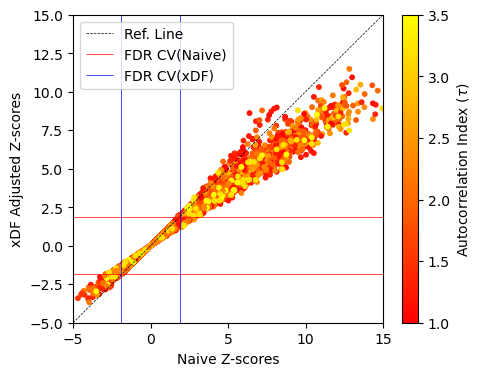

In [9]:
# apply xDF adjustment when the null not true
aci_ex = calc_aci(X_ex.T, n_timepoints=n_timepoints)
xdf_ex = xdf.calc_xdf(X_ex.T, n_timepoints=n_timepoints, truncate_variance=False)

# find FDR-controlling threshold, and CE density threshold
z_naive = connectome.sym_matrix_to_vec(xdf_ex["znaive"], discard_diagonal=True)
fdr_naive = glm.fdr_threshold(z_naive, alpha=0.05)

z_xdf = connectome.sym_matrix_to_vec(xdf_ex["z"], discard_diagonal=True)
fdr_xdf = glm.fdr_threshold(z_xdf, alpha=0.05)


# plot results
fig, ax = plt.subplots(figsize=(5, 4))
ax.scatter(z_naive, z_xdf, s=10, c=aci_ex.repeat(47), cmap="autumn")

# add colorbar
sm = plt.cm.ScalarMappable(cmap="autumn", norm=plt.Normalize(vmin=1, vmax=3.5))
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label(r"Autocorrelation Index ($\tau$)")

limits = [-5, 15]
ax.set_xlim(*limits)
ax.set_ylim(*limits)
ax.plot(limits, limits, c="k", lw=0.5, ls="dashed", label="Ref. Line")

ax.hlines([-fdr_naive, fdr_naive], *limits, lw=0.5, color="r", label="FDR CV(Naive)")
ax.vlines([-fdr_xdf, fdr_xdf], *limits, lw=0.5, color="b", label="FDR CV(xDF)")
ax.legend()

ax.set_xlabel("Naive Z-scores")
ax.set_ylabel("xDF Adjusted Z-scores")
